# Árvores de regressão - exercícios 01

*Atenção! Devido descontinuação da base de imóveis boston os alunos devem utilizar a base de dados que se encontra em anexo.*

A base que utilizaremos contem os dados dos imóveis da california.
Considerem como variável Target (a ser prevista) a coluna median_house_value.
O dataset é muito semelhante ao de boston, contendo localização, quartos, banheiros e outras variáveis interessantes para construção do modelo.

In [65]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn import tree
from sklearn.model_selection import train_test_split


from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score



### 1. Certifique-se de que esta base está no formato adequado para o scikitlearn.
ok, essa tarefa é tão fácil que você vai até desconfiar. Mas é preciso ter confiança sobre os dados que se usa ;)

In [5]:
df = pd.read_csv('housing.csv',na_values=('NA','',' ','nan','NAN','na'))
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.shape

(20640, 10)

In [6]:
print(df.info())
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [7]:
df['total_bedrooms'].fillna(df['total_bedrooms'].mean(), inplace=True)

In [8]:
print(df.info())
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

### 2.  Visualize a matriz de correlação, e veja se aparentemente você encontra alguma variável com potencial preditivo interessante.

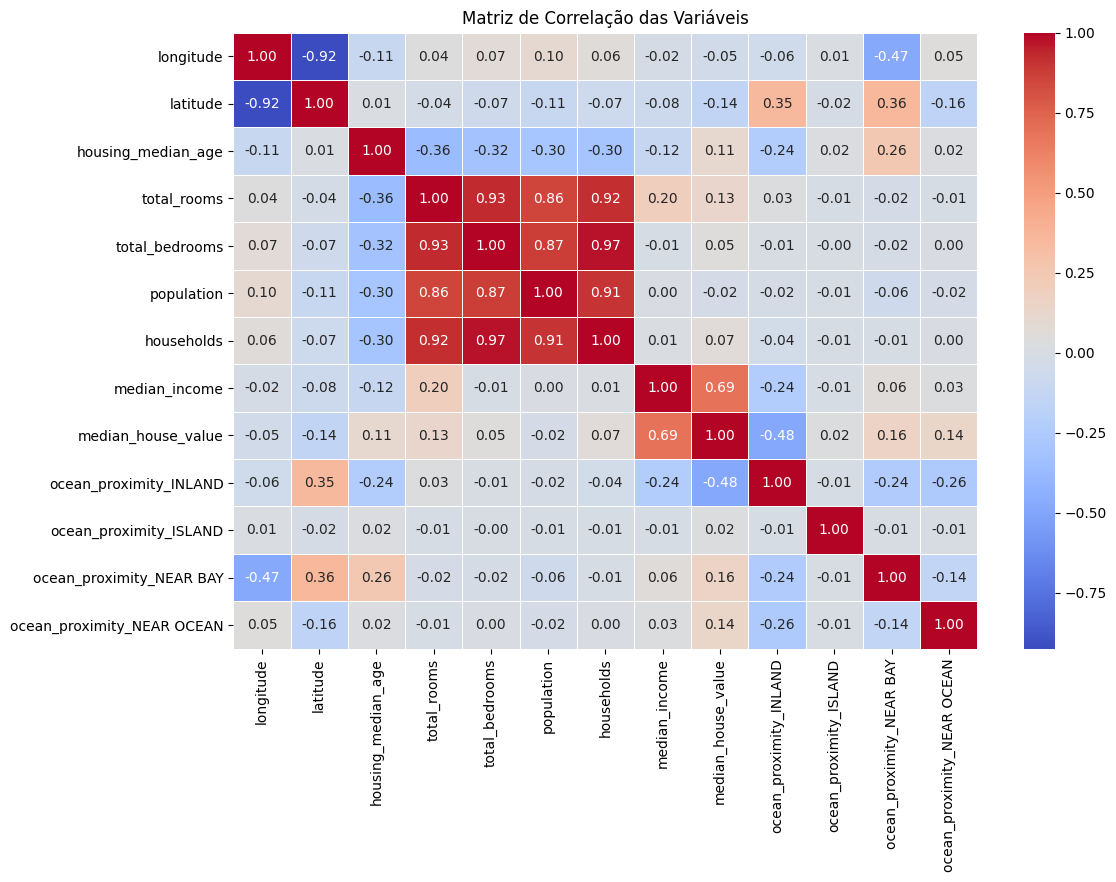

In [12]:
df = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=True)

correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação das Variáveis')
plt.show()

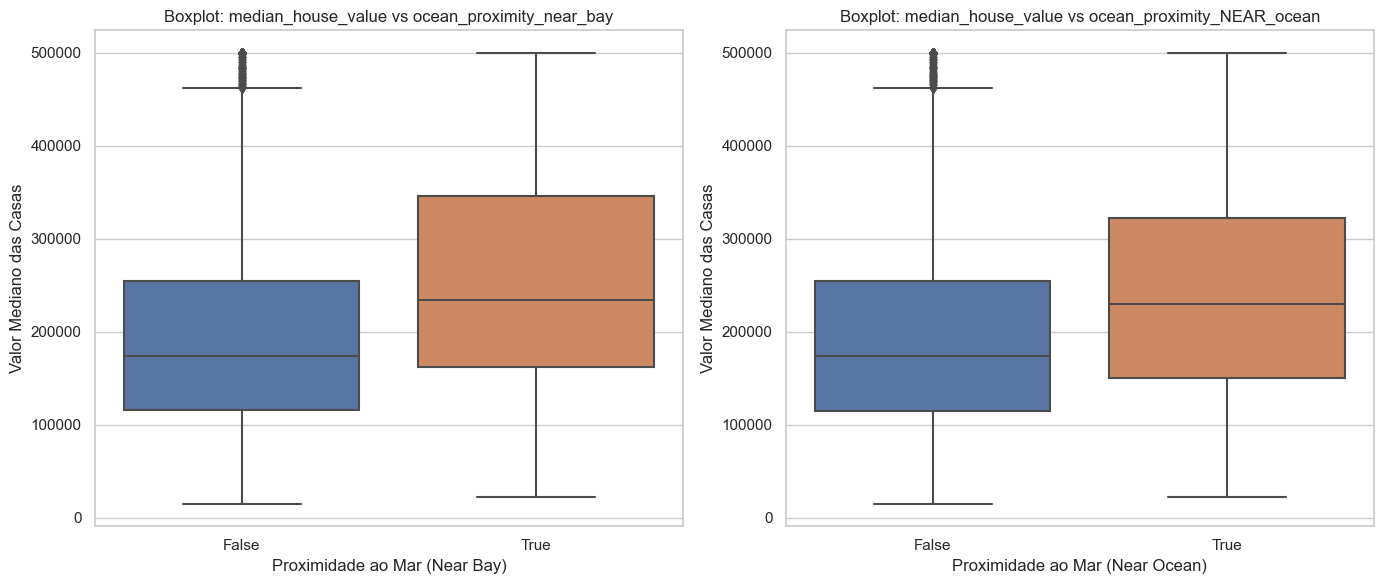

In [14]:
sns.set(style="whitegrid")

# Criar a figura com subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot para ocean_proximity_near_bay
sns.boxplot(ax=axes[0], x='ocean_proximity_NEAR BAY', y='median_house_value', data=df)
axes[0].set_title('Boxplot: median_house_value vs ocean_proximity_near_bay')
axes[0].set_ylabel('Valor Mediano das Casas')
axes[0].set_xlabel('Proximidade ao Mar (Near Bay)')

# Boxplot para ocean_proximity_NEAR_ocean
sns.boxplot(ax=axes[1], x='ocean_proximity_NEAR OCEAN', y='median_house_value', data=df)
axes[1].set_title('Boxplot: median_house_value vs ocean_proximity_NEAR_ocean')
axes[1].set_ylabel('Valor Mediano das Casas')
axes[1].set_xlabel('Proximidade ao Mar (Near Ocean)')

# Exibir os gráficos
plt.tight_layout()
plt.show()

ocean_proximity_NEAR BAY e ocean_proximity_NEAR OCEAN possuem uma correlação com o median_house_value. Isto pode ser explicado pelo fato de que naturalmente casas próximas às praias são valorizadas no mercado. Esta suposição pode ser confirmada no boxplot acima. Portanto variáveis possuem potencial preditor pois capturam uma mudança significativa no valor medio das casas com base na localização.

### 3. Separe os dados em validação e teste

In [40]:
# Identify object type columns
object_columns = df.select_dtypes(include=['object']).columns.tolist()

# Dummify categorical variables
df_dummies = pd.get_dummies(df, columns=object_columns, drop_first=True)

# Ensure ocean_proximity_NEAR BAY is treated as a categorical variable
# Here, I'm assuming that the variable is meant to be binary (0 or 1)
# If it's not binary, you might want to use another approach
df_dummies['ocean_proximity_NEAR BAY'] = df_dummies['ocean_proximity_NEAR BAY'].astype(int)

df_Y = df_dummies['ocean_proximity_NEAR BAY']  # Assuming this column is now dummified
df_X = df_dummies.drop('ocean_proximity_NEAR BAY', axis=1)


X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=42)


ocean_proximity_NEAR BAY
0    14658
1     1854
Name: count, dtype: int64

### 4. Treine duas árvores, uma com profundidade máxima = 8, outra com profundidade máxima = 2.

Acurácia da Base de Treino com Profundidade 8: 99.99%


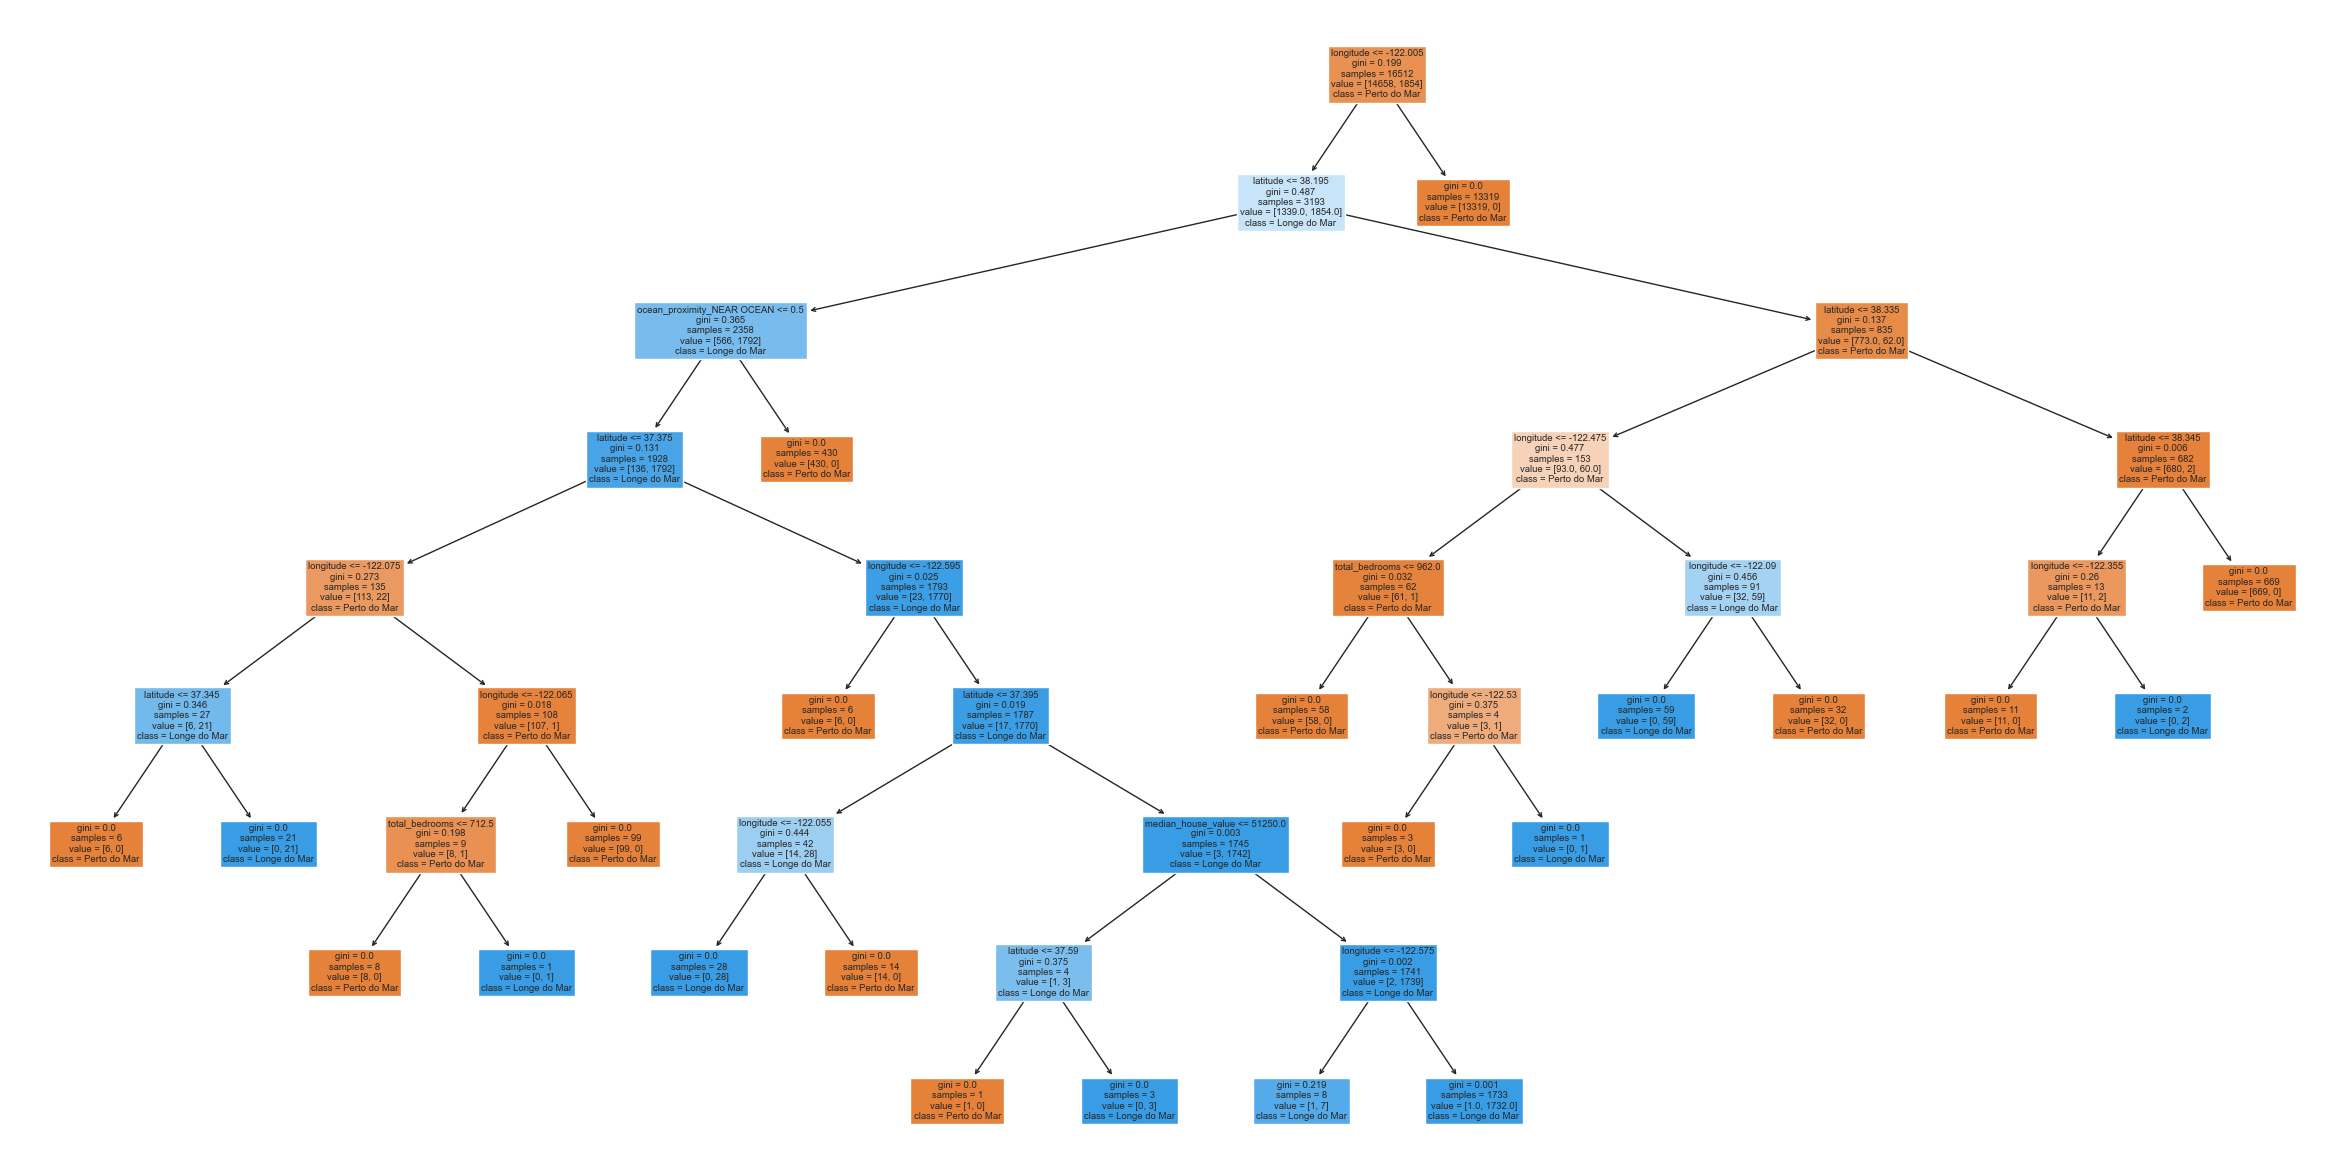

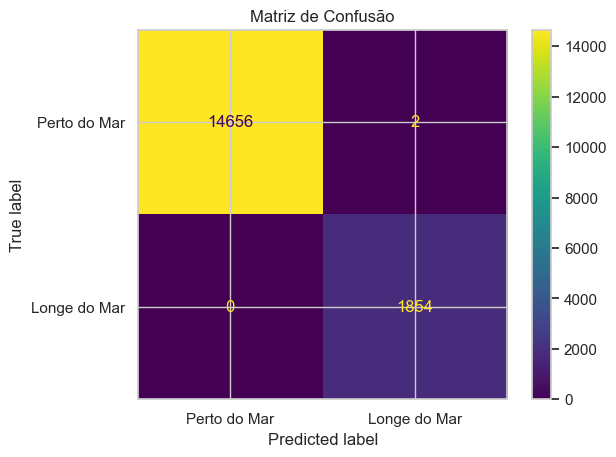

In [62]:
clf2 = DecisionTreeClassifier(max_depth=8, random_state=123)
clf2.fit(X_train, Y_train)

# Plot the decision tree
plt.figure(figsize=(30, 15))
plot_tree(clf2, 
          filled=True, 
          class_names=['Perto do Mar', 'Longe do Mar'],
          feature_names=X_train.columns)

# Predict on the training data
y_pred = clf2.predict(X_train)

# Create the confusion matrix
cm2 = confusion_matrix(Y_train, y_pred, labels=clf2.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=['Perto do Mar', 'Longe do Mar'])
disp.plot()
plt.title('Matriz de Confusão')

# Calculate accuracy
acc3 = accuracy_score(Y_train, y_pred)
print(f"Acurácia da Base de Treino com Profundidade 8: {acc3 * 100:.2f}%")

Acurácia da Base de Treino com Profundidade 10 e Mínimo de Observação por folha de 5: 99.99%


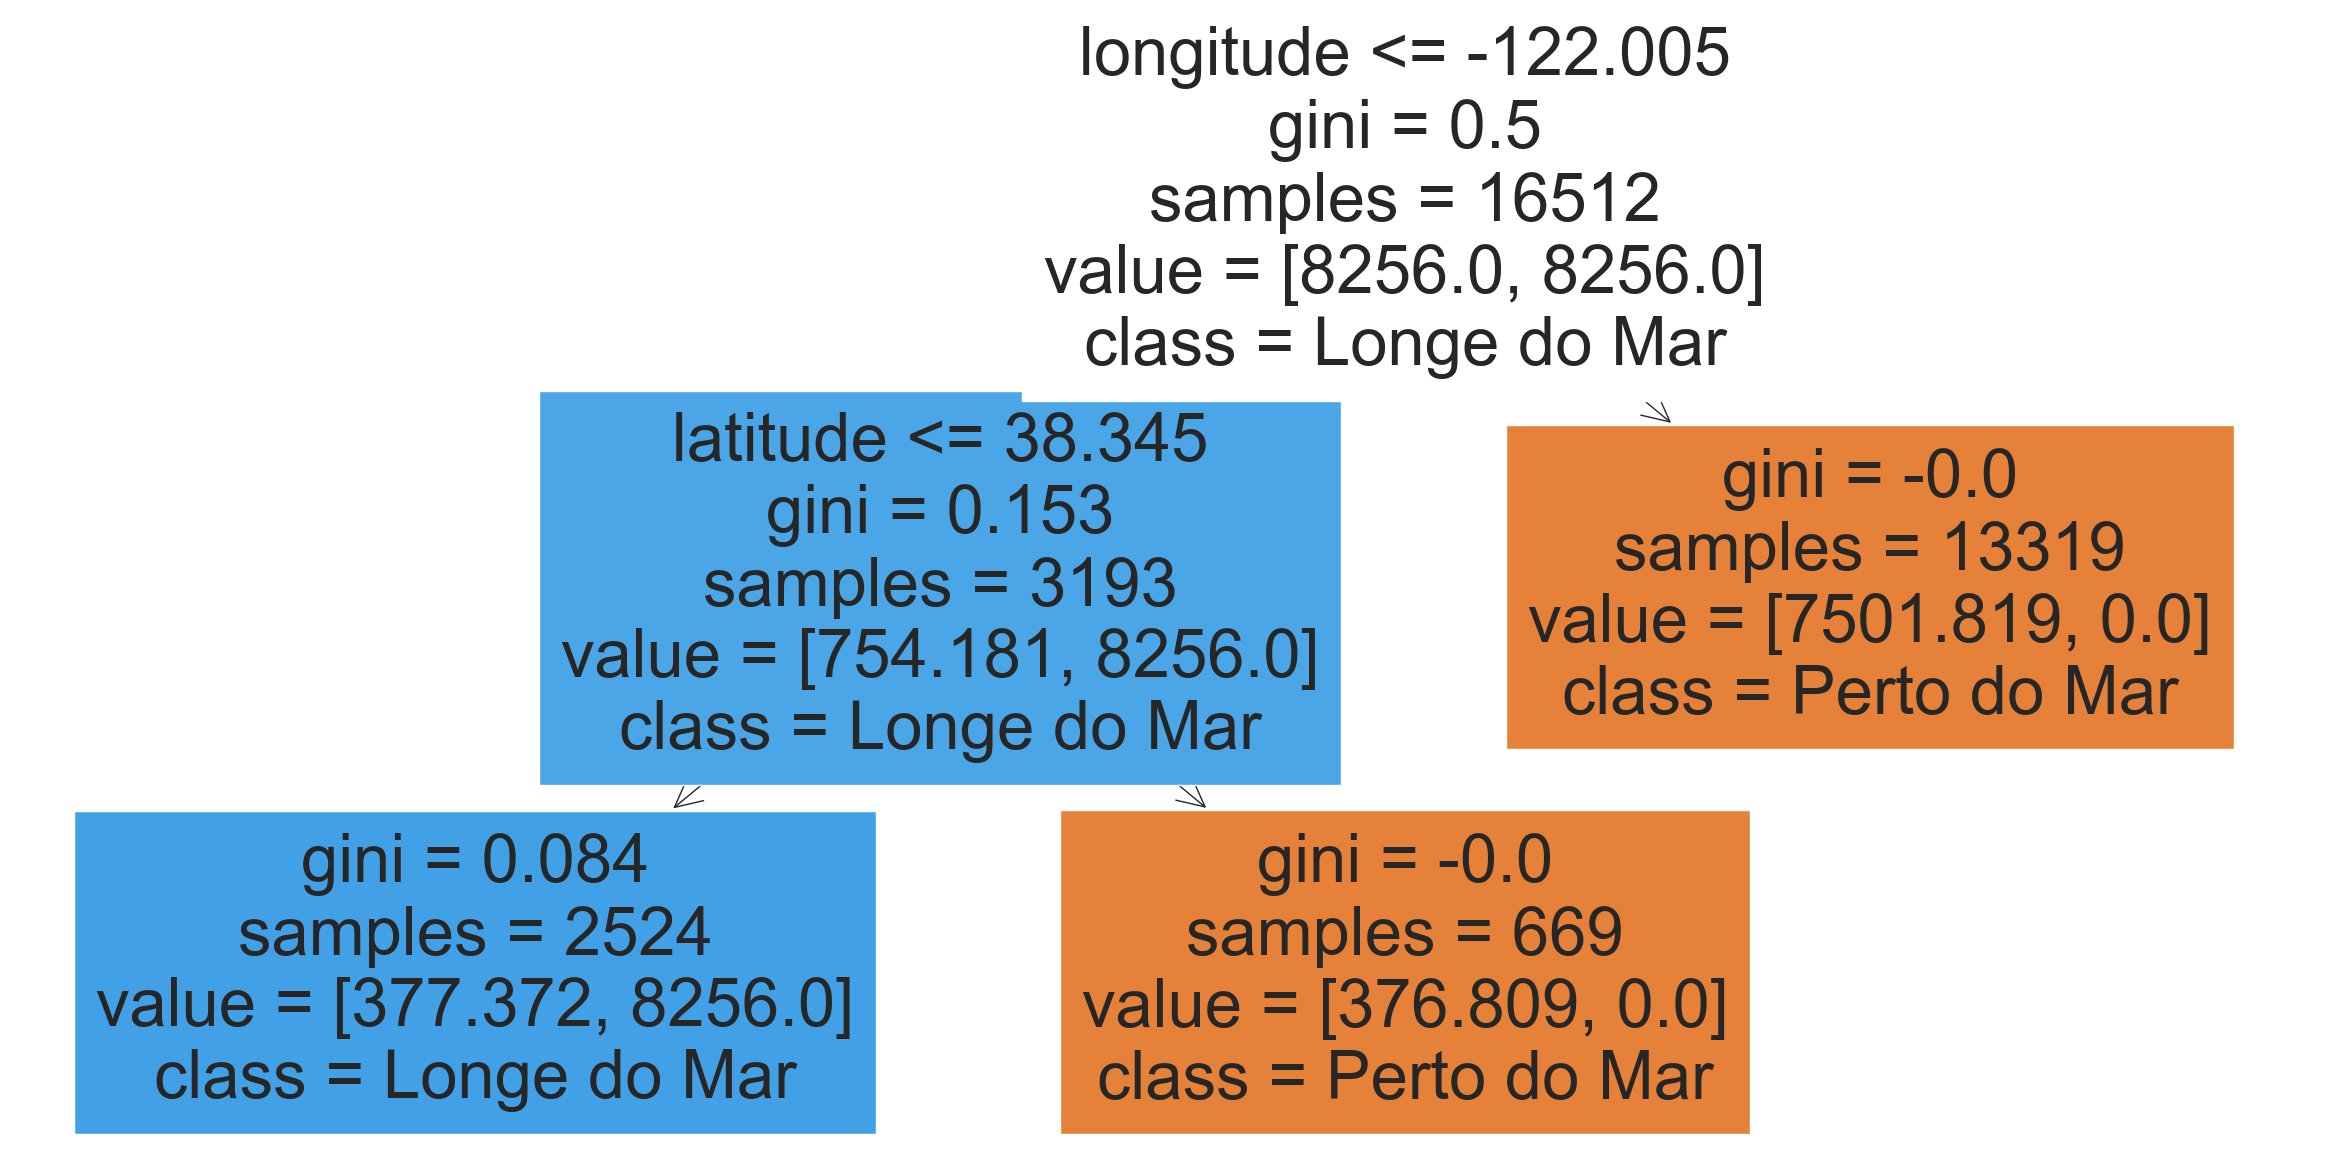

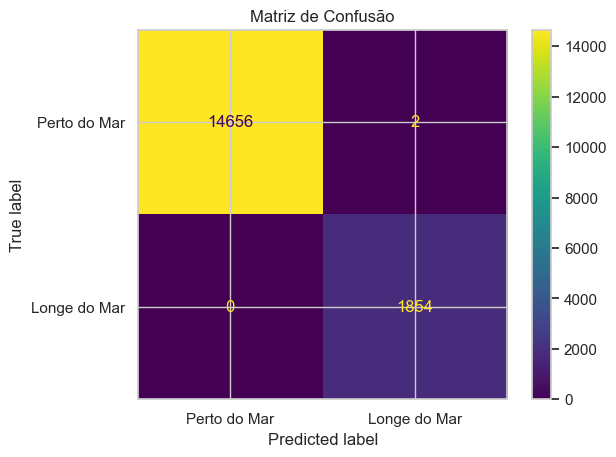

In [63]:
clf3 = DecisionTreeClassifier(max_depth=2,random_state=123,class_weight='balanced')
clf3 = clf3.fit(X_train,Y_train)

plt.figure(figsize=(30,15))
plot_tree(clf3,          
          filled=True, 
          class_names=['Perto do Mar', 'Longe do Mar'],
          feature_names=X_train.columns);

y_pred  = clf2.predict(X_train)

cm3 = confusion_matrix(Y_train, y_pred,labels=clf2.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=['Perto do Mar', 'Longe do Mar'])
disp.plot()
plt.title('Matriz de Confusão')
acc3 = accuracy_score(Y_train, y_pred )
print(f"Acurácia da Base de Treino com Profundidade 10 e Mínimo de Observação por folha de 5: {acc3 * 100:.2f}%")

Acurácia da Base de Treino com Profundidade 10 e Mínimo de Observação por folha de 5: 95.69%


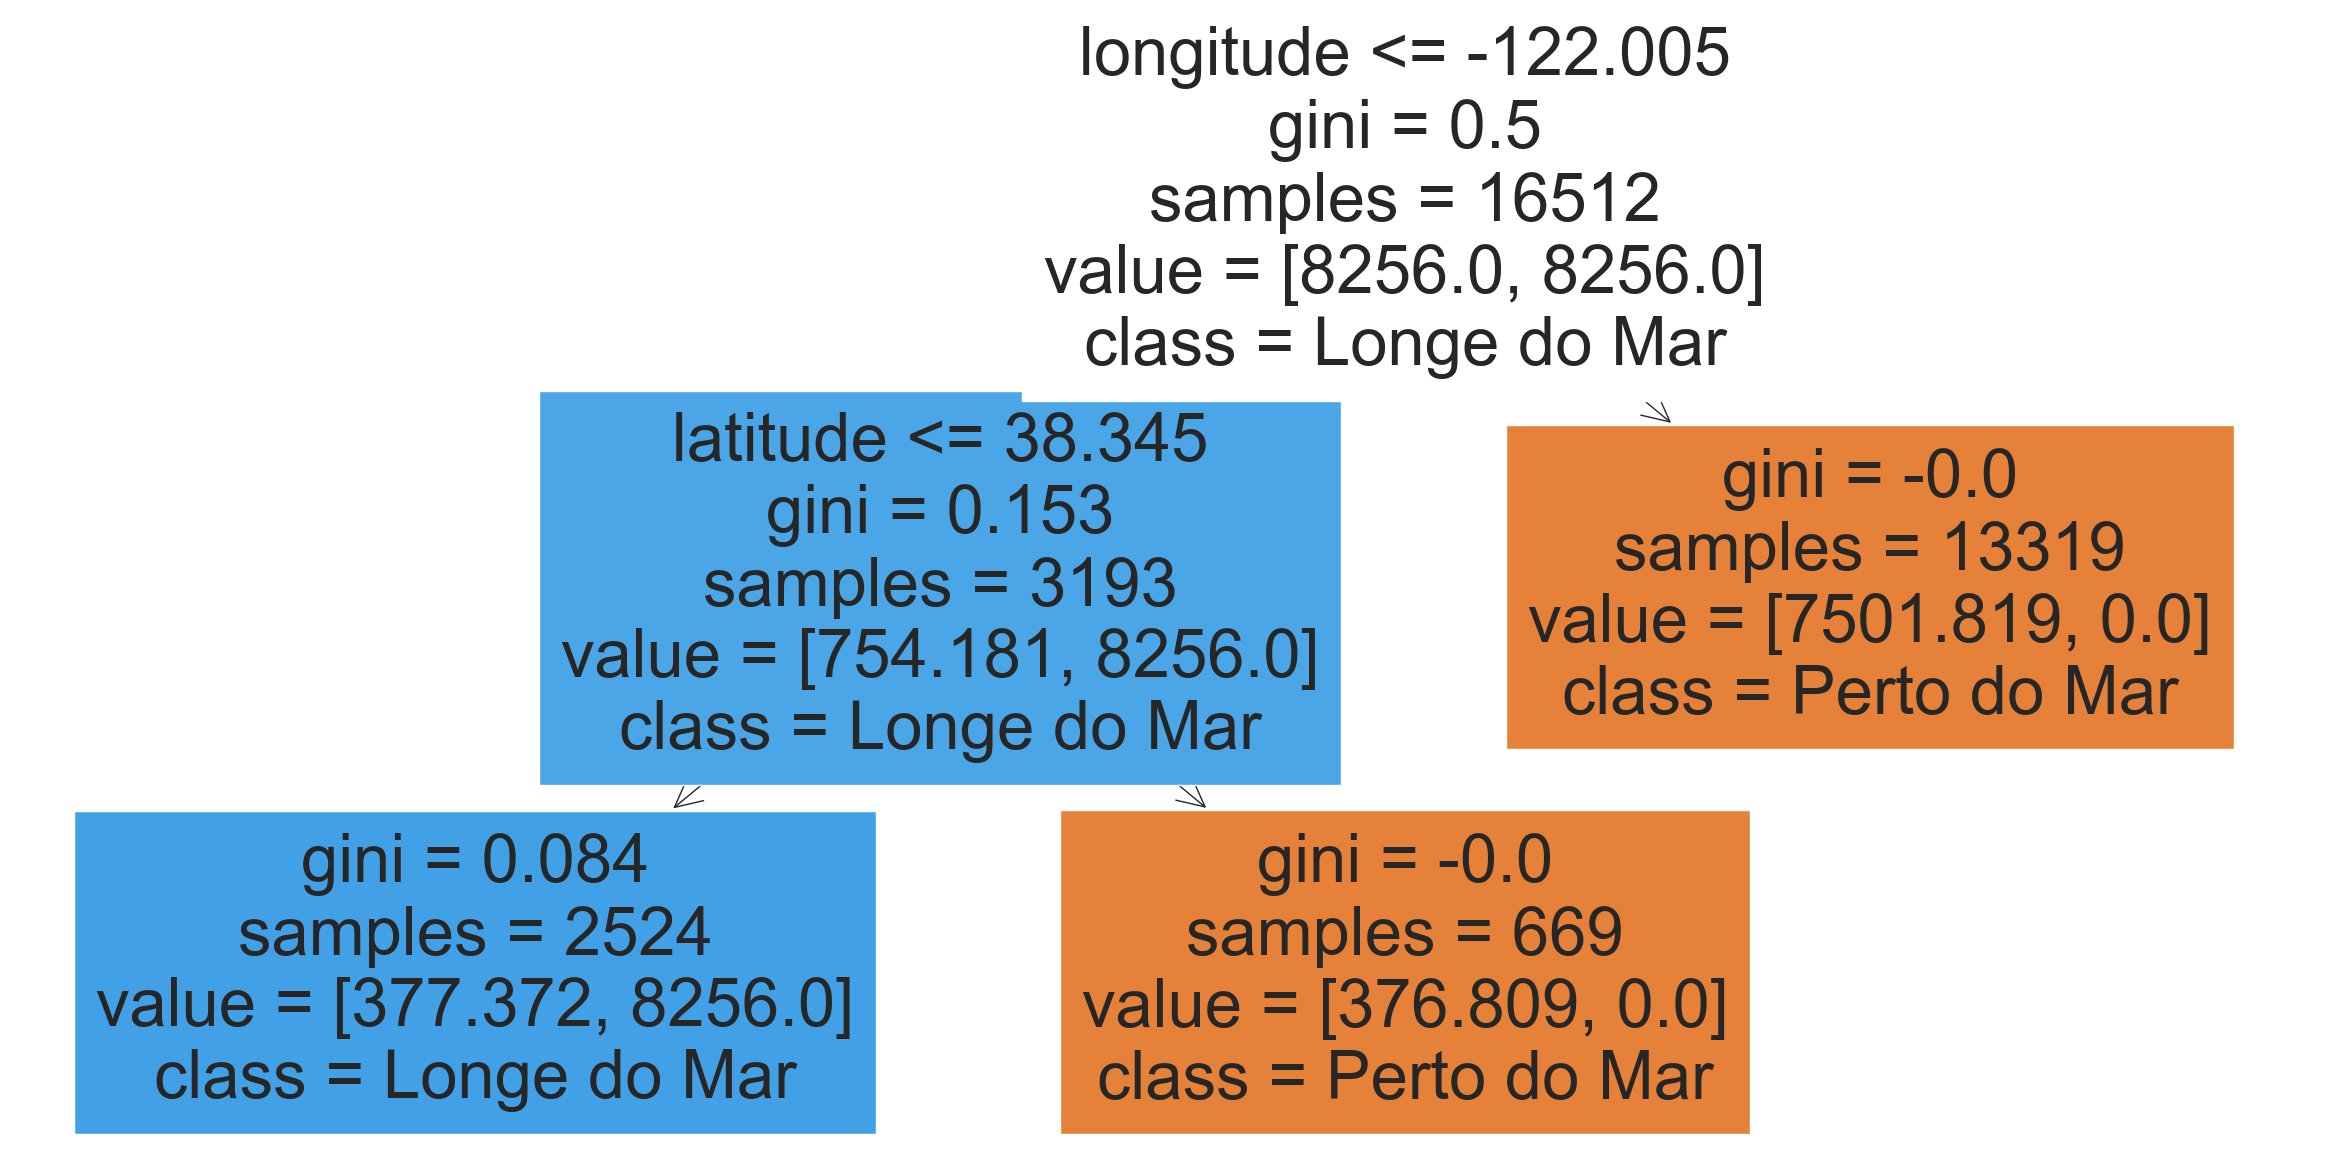

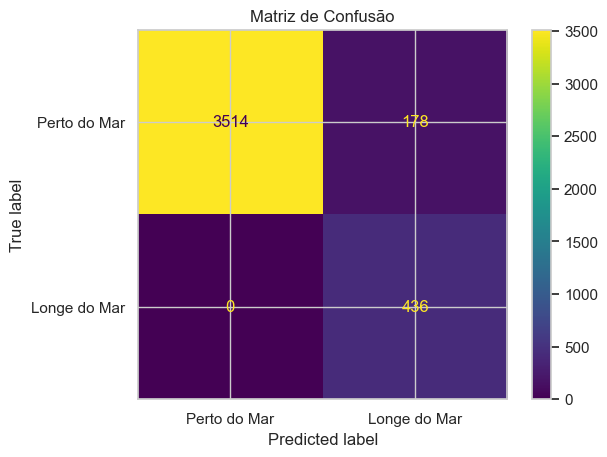

In [54]:
plt.figure(figsize=(30,15))
plot_tree(clf2,          
          filled=True, 
          class_names=['Perto do Mar', 'Longe do Mar'],
          feature_names=X_test.columns);

y_pred  = clf2.predict(X_test)

cm3 = confusion_matrix(Y_test, y_pred,labels=clf2.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=['Perto do Mar', 'Longe do Mar'])
disp.plot()
plt.title('Matriz de Confusão')
acc3 = accuracy_score(Y_test, y_pred )
print(f"Acurácia da Base de Treino com Profundidade 10 e Mínimo de Observação por folha de 5: {acc3 * 100:.2f}%")

Acurácia da Base de Treino com Profundidade 10 e Mínimo de Observação por folha de 5: 95.69%


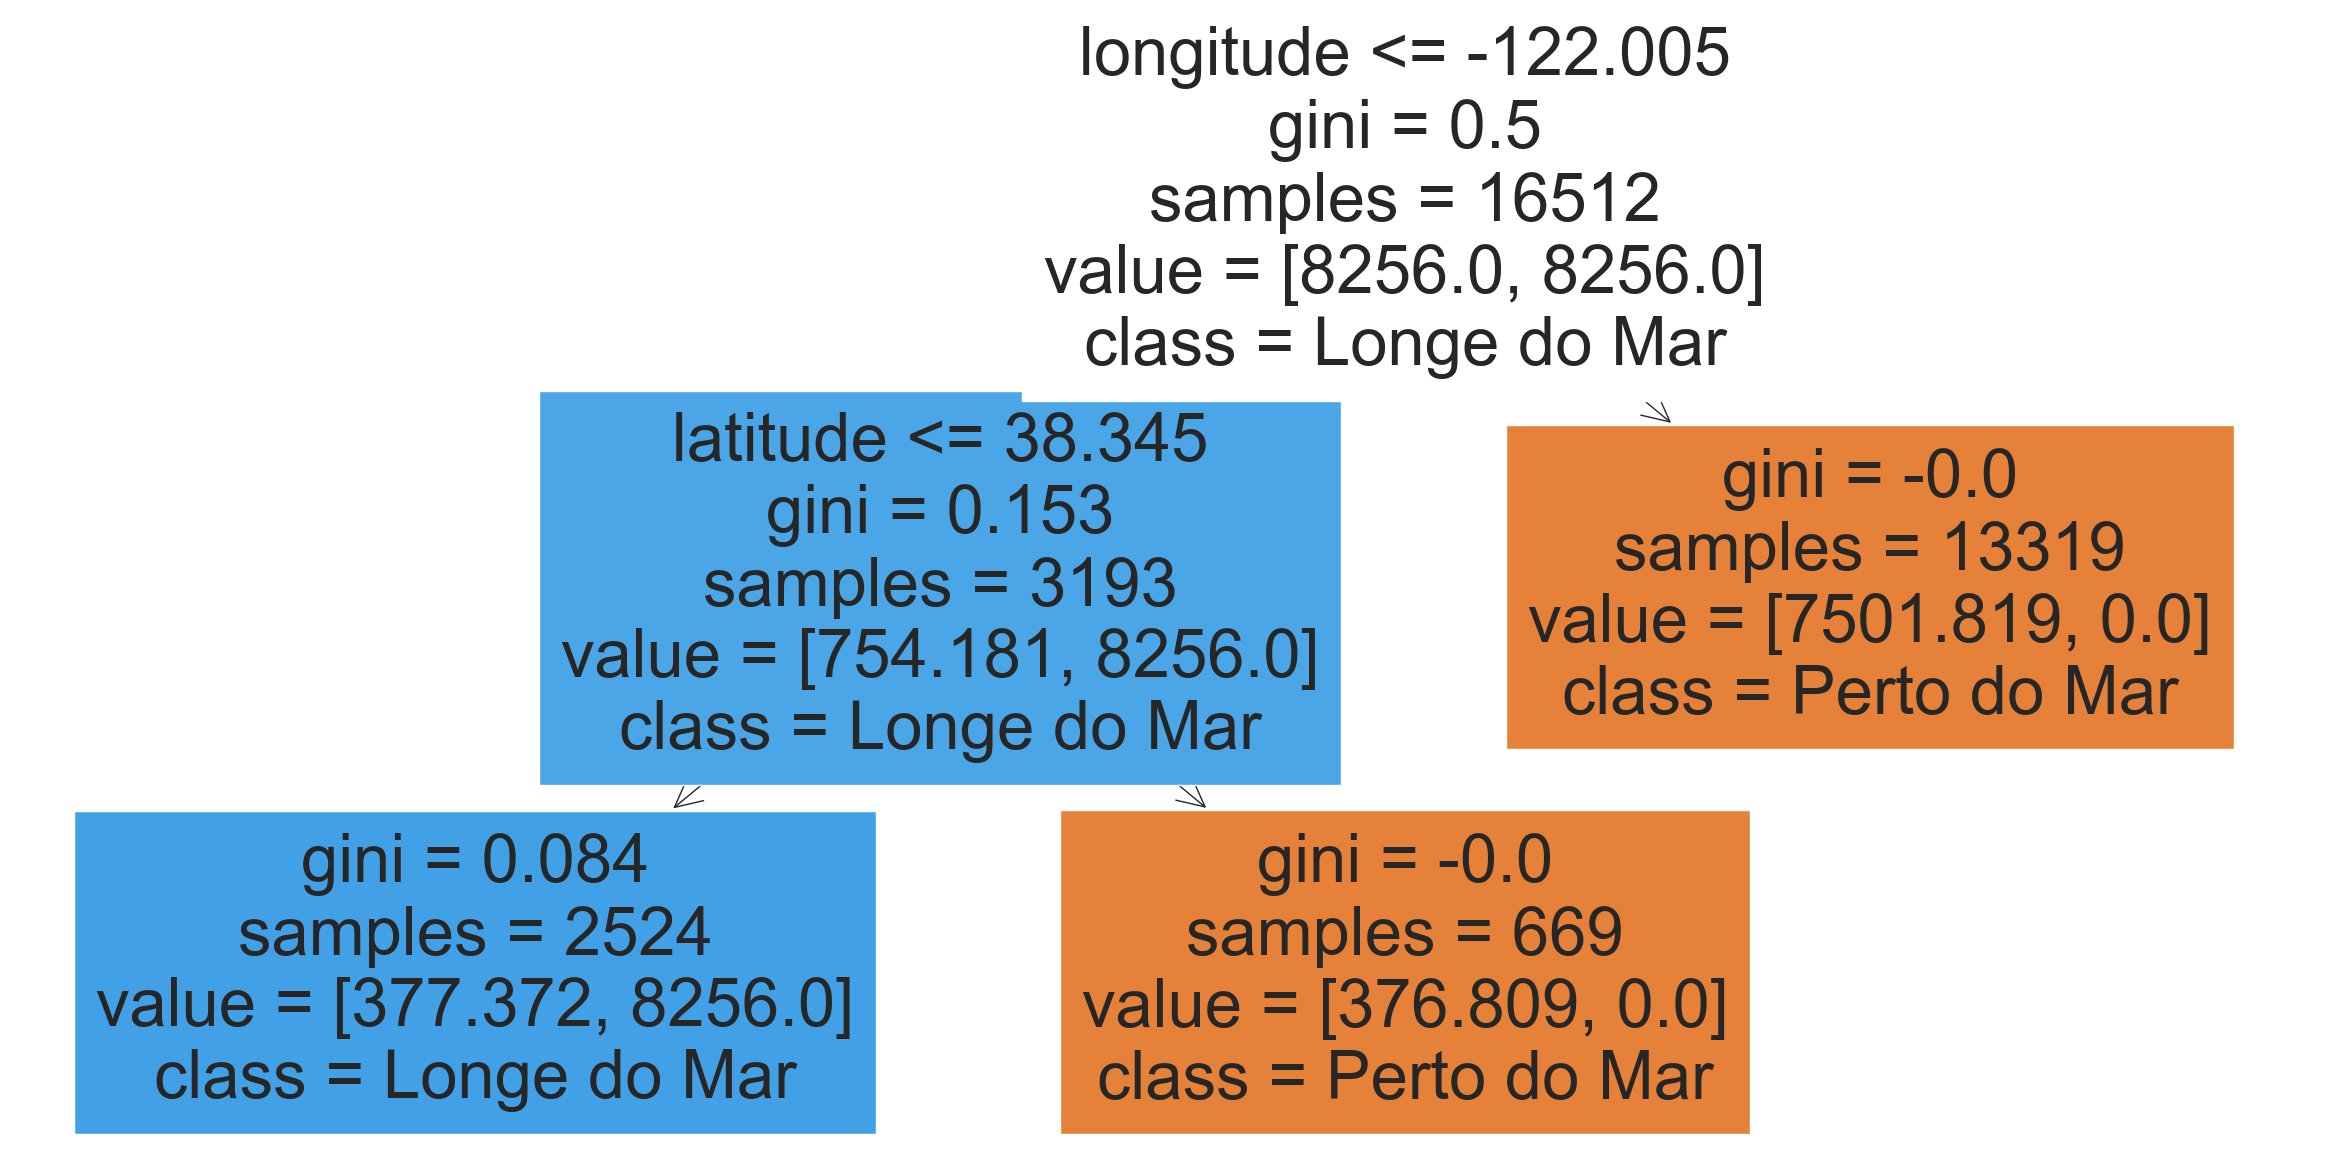

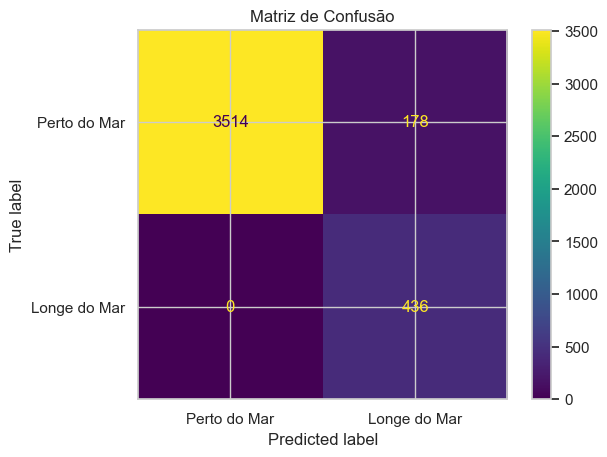

In [53]:

plt.figure(figsize=(30,15))
plot_tree(clf3,          
          filled=True, 
          class_names=['Perto do Mar', 'Longe do Mar'],
          feature_names=X_test.columns);

y_pred  = clf3.predict(X_test)

cm3 = confusion_matrix(Y_test, y_pred,labels=clf3.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=['Perto do Mar', 'Longe do Mar'])
disp.plot()
plt.title('Matriz de Confusão')
acc3 = accuracy_score(Y_test, y_pred )
print(f"Acurácia da Base de Treino com Profundidade 10 e Mínimo de Observação por folha de 5: {acc3 * 100:.2f}%")

### 5. Calcule o MSE de cada uma das árvores do item anterior para a base de treinamento e para a base de testes.

In [67]:
y_train_pred_8 = clf2.predict(X_train)
y_test_pred_8 = clf2.predict(X_test)

y_train_pred_3 = clf3.predict(X_train)
y_test_pred_3 = clf3.predict(X_test)

mse_train = mean_absolute_error(Y_train, y_train_pred_8)
mse_test = mean_absolute_error(Y_test, y_test_pred_8)

mse_train2 = mean_absolute_error(Y_train, y_train_pred_3)
mse_test2 = mean_absolute_error(Y_test, y_test_pred_3)
print(f"Mean Absolute Error (MSE) na base de treino com profundidade 8: {mse_train:.2f}")
print(f"Mean Absolute Error (MSE) na base de teste com profundidade 8: {mse_test:.2f}")
print(f"Mean Absolute Error (MSE) na base de treino com profundidade 3: {mse_train2:.2f}")
print(f"Mean Absolute Error (MSE) na base de teste com profundidade 3: {mse_test2:.2f}")

Mean Absolute Error (MSE) na base de treino com profundidade 8: 0.00
Mean Absolute Error (MSE) na base de teste com profundidade 8: 0.00
Mean Absolute Error (MSE) na base de treino com profundidade 3: 0.04
Mean Absolute Error (MSE) na base de teste com profundidade 3: 0.04


### 6. Com base nos resultados do item anterior, qual árvore te parece mais adequada?

Um MSE muito poequeno pode seignificar uma overfitting do modelo, entretando o fato de não haver aumento no MSE quando utilizada a base de teste também pode significar que a arvore com profundidade 8 é adequada para generalizar bem novos dados.

### 7. Faça uma visualização gráfica dessa árvore. Vamos discutir importância de variável mais adiante, mas veja a sua árvore, e pense um pouco: qual variável te parece mais "importante" na árvore?

O nó raiz aparenta ser o mais importante segundo o algoritmo que avalia a "impureza" dos nós e decide quais variaveis melhor dividem os dados em classes.